### План:

1. Научимся извлекать базовые и статистические мета-признаки, это должно быть просто. (прим. - ничего не сказано о том, как много должно быть мета-признаков)
2. Затем найдем структурные мета-признаки на основе какой-нибудь модели из sklearn
3. Проверим инвариант
4. Возьмем из sklearn 3 модели и прогоним их по файлам, результаты будем собирать, а именно:
   4.1. Accuracy предсказаний
   4.2. Алгоритм, показавший наилучший результат
5. Соберем набор мета-данных ("мета-набор данных" в условии задачи)
6. Посчитаем среднюю accuracy, чтобы понять смысл использования мета-признаков
7. Пусть еще несколько моделей предсказывают алгоритм, показавший наилучший результат
8. Посчитаем среднюю accuracy по предложенному лучшей из моделей алгоритму
9. Сделаем выводы


In [117]:
import pandas as pd
from scipy.io import arff
import os
from metafeatures import *
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [118]:
structural_model = LinearRegression()
scaler = StandardScaler()

In [119]:
def dummify_df(df: pd.DataFrame):
# -----> one-hot everything & scale
        new_df = df.fillna(0)
        new_df = new_df.replace(np.inf, 1000)
        new_df = new_df.replace(-np.inf, -1000)
        new_df = pd.DataFrame(scaler.fit_transform(pd.get_dummies(new_df)))
        new_df = new_df.astype(np.float32)
        return new_df

In [120]:
def get_structural_metafeatures(df: pd.DataFrame):
        return structural_metafeatures(dummify_df(df), structural_model)

In [121]:
def get_metafeatures(df: pd.DataFrame):
    xs = df.iloc[:, :-1]
    ys = df.iloc[:, -1]
    ys.squeeze()

    metafeatures = {}
    metafeatures.update(basic_metafeatures(xs, ys))
    metafeatures.update(statistics_metafeatures(xs, ys))
    metafeatures.update(get_structural_metafeatures(df))
    return metafeatures

In [122]:
cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, '../data')
dir = os.listdir(data_path)

In [123]:
df = pd.DataFrame(arff.loadarff(os.path.join(data_path, dir[0]))[0])
df_shuffled = df.sample(frac=1)
ys = df_shuffled.iloc[:, -1]
df_shuffled = df_shuffled.iloc[:, :-1]
df_shuffled = df_shuffled[np.random.default_rng(
    seed=42).permutation(df_shuffled.columns.values)]
df_shuffled = df_shuffled.merge(ys, left_index=True, right_index=True)


m1 = get_metafeatures(df)
m2 = get_metafeatures(df_shuffled)

for key in m1.keys():
    if m1[key] == m2[key]:
        print(f'{key} - ok')
    else:
        print(f'{key} - difference: {m1[key]:.3f} vs {m2[key]:.3f}')


row_count - ok
col_count - ok
class_count - ok
categorial_count - ok
numerical_count - ok
min - ok
max - ok
mean - ok
categorial_counts_min - ok
categorial_counts_max - ok
categorial_counts_mean - ok
categorial_entropy_min - ok
categorial_entropy_max - ok
categorial_entropy_mean - ok
structural_min - ok
structural_max - difference: 0.296 vs 0.259
structural_mean - difference: -0.077 vs -0.053


Моделька научилась по-другому, поэтому разница в цифрах. Для сравнения, результат на различных наборах данных:

In [124]:
df = pd.DataFrame(arff.loadarff(os.path.join(data_path, dir[0]))[0])
df_2 = pd.DataFrame(arff.loadarff(os.path.join(data_path, dir[1]))[0])


m1 = get_metafeatures(df)
m2 = get_metafeatures(df_2)

for key in m1.keys():
    if m1[key] == m2[key]:
        print(f'{key} - ok')
    else:
        print(f'{key} - difference: {m1[key]:.3f} vs {m2[key]:.3f}')

row_count - difference: 898.000 vs 148.000
col_count - difference: 38.000 vs 18.000
class_count - difference: 5.000 vs 4.000
categorial_count - difference: 32.000 vs 15.000
numerical_count - difference: 6.000 vs 3.000
min - difference: 0.000 vs 1.000
max - difference: 4880.000 vs 8.000
mean - difference: 348.504 vs 2.045
categorial_counts_min - difference: 1.000 vs 2.000
categorial_counts_max - ok
categorial_counts_mean - difference: 2.438 vs 2.933
categorial_entropy_min - difference: -0.000 vs 0.190
categorial_entropy_max - difference: 1.422 vs 1.752
categorial_entropy_mean - difference: 0.321 vs 0.775
structural_min - difference: -2.065 vs -0.106
structural_max - difference: 0.296 vs 0.956
structural_mean - difference: -0.077 vs 0.009


In [125]:
def fit_and_compute_acc(df: pd.DataFrame, model):
    df = dummify_df(df)
    xs = df.iloc[:, :-1]
    ys = df.iloc[:, -1]
    ys.squeeze()
    ys_unique = ys.unique()
    ys = [min(enumerate(ys_unique), key=lambda t: abs(t[1] - y))[0] for y in ys]
    x_train, x_test, y_train, y_test = train_test_split(xs, ys)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

In [126]:
meta_df = pd.DataFrame(columns=['row_count', 'col_count', 'class_count', 'categorial_count', 'numerical_count', 'min', 'max', 'mean', 'categorial_counts_min', 'categorial_counts_max',
                       'categorial_counts_mean', 'categorial_entropy_min', 'categorial_entropy_max', 'categorial_entropy_mean', 'structural_min', 'structural_max', 'structural_mean', 'best_fit', 'acc_1', 'acc_2', 'acc_3'])


model_1 = KNeighborsClassifier()
model_2 = RandomForestClassifier()
model_3 = SGDClassifier()
models = [model_1, model_2, model_3]

for file_name in tqdm(dir):
    if file_name == 'data.csv':
        continue
    if len(meta_df.index) == 500:
        break
    try:
        df = pd.DataFrame(arff.loadarff(os.path.join(data_path, file_name))[0])
        m = get_metafeatures(df)
        if np.nan in m:
            continue
        accs = [fit_and_compute_acc(df, model) for model in models]
        best_fit = np.argmax(accs)

        meta_df.loc[len(meta_df.index)] = list(m.values()) + [best_fit] + accs
    except:
        continue
  


print(meta_df)


 71%|███████▏  | 531/745 [09:30<03:49,  1.07s/it]  

     row_count  col_count  class_count  categorial_count  numerical_count  \
0        898.0       38.0          5.0              32.0              6.0   
1        148.0       18.0          4.0              15.0              3.0   
2         76.0       45.0          2.0              45.0              0.0   
3        339.0       17.0          2.0              17.0              0.0   
4        214.0        9.0          2.0               0.0              9.0   
..         ...        ...          ...               ...              ...   
495      209.0        6.0          2.0               0.0              6.0   
496      111.0        3.0          2.0               0.0              3.0   
497     3107.0        6.0          2.0               0.0              6.0   
498      195.0       11.0          2.0              10.0              1.0   
499       62.0        7.0          2.0               0.0              7.0   

              min        max          mean  categorial_counts_min  \
0    0

In [128]:
meta_df = meta_df.replace(np.nan, -1000)

In [129]:
print(meta_df['acc_1'].mean())
print(meta_df['acc_2'].mean())
print(meta_df['acc_3'].mean())

0.6535030792587436
0.6845183824162164
0.661446848610319


In [130]:
print(meta_df['acc_1'].min() ,meta_df['acc_1'].max()) 
print(meta_df['acc_2'].min() ,meta_df['acc_2'].max()) 
print(meta_df['acc_3'].min() ,meta_df['acc_3'].max()) 

0.0 1.0
0.0 1.0
0.0 1.0


c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


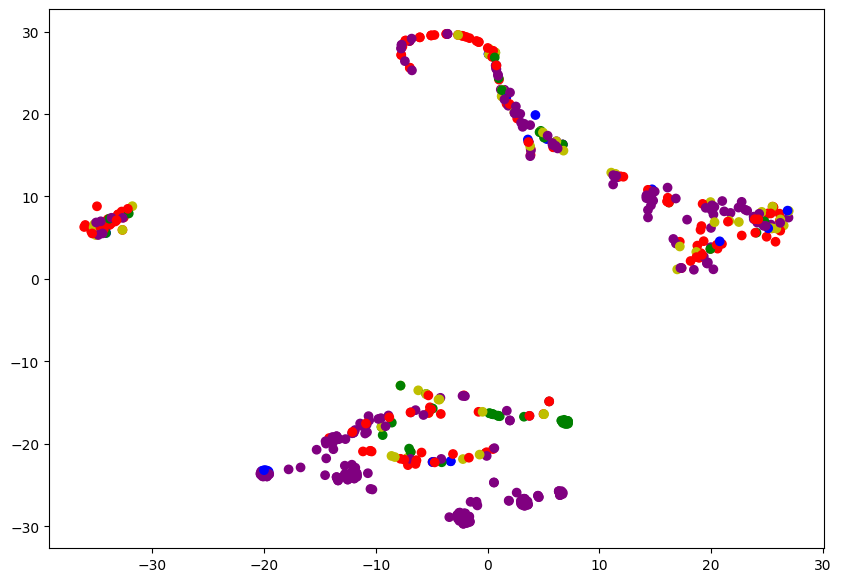

In [131]:
tsne = TSNE(n_components=2, random_state=42)

meta_df_2d = tsne.fit_transform(meta_df.iloc[:, :-4])

colors = np.where(meta_df['class_count'] == 2, 'r', 
np.where(meta_df['class_count'] < 5, 'y', 
np.where(meta_df['class_count'] < 7, 'g', 
np.where(meta_df['class_count'] < 10, 'b', 'purple'))))

plt.figure(figsize=(10,7))
plt.scatter(meta_df_2d[:, 0], meta_df_2d[:, 1], c=colors )
plt.show()

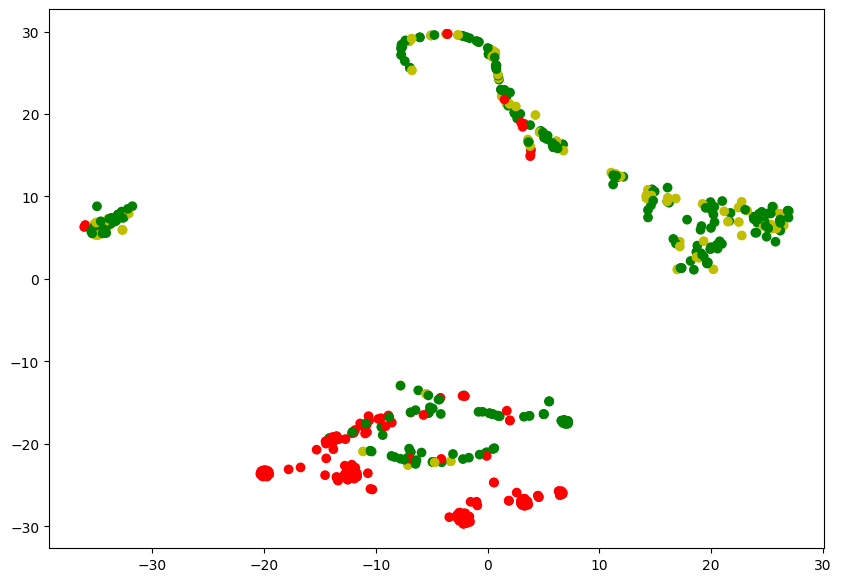

In [132]:
colors = np.where(meta_df['acc_1'] < 0.5, 'r',
                  np.where(meta_df['acc_1'] < 0.9, 'y', 'g'))
plt.figure(figsize=(10, 7))
plt.scatter(meta_df_2d[:, 0], meta_df_2d[:, 1], c=colors)
plt.show()


In [134]:
meta_df_xs = meta_df.iloc[:, :-4]
meta_df_ys = meta_df.iloc[:, -4]
meta_df_ys.astype(np.int)

C:\Users\mars\AppData\Local\Temp\ipykernel_3304\1264214195.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  meta_df_ys.astype(np.int)


0      2
1      0
2      1
3      1
4      1
      ..
495    0
496    0
497    0
498    2
499    2
Name: best_fit, Length: 500, dtype: int32

Что хотим: определить лучший алгоритм

Наивные алгоритмы: всегда 1-й, всегда 2-й, всегда 3-й (так как у 2-го лучше средняя accuracy, по идее именно он является наивным алгоритмом)

In [139]:
print(f'always 1: {accuracy_score(meta_df_ys, [0] * len(meta_df_ys.index))}')
print(f'always 2: {accuracy_score(meta_df_ys, [1] * len(meta_df_ys.index))}')
print(f'always 3: {accuracy_score(meta_df_ys, [2] * len(meta_df_ys.index))}')

always 1: 0.568
always 2: 0.324
always 3: 0.108


Однако, оказывается в большинстве случаев лучше оказывается первый алгоритм (knn)

Теперь обучим те же алгоритмы на мета наборе данных (а почему нет? все они классификаторы) + DecisionTree для разнообразия

In [140]:
def fit_model_meta(meta_xs, meta_ys, model):
    res = []
    for _ in range(10):
        x_train, x_test, y_train, y_test = train_test_split(meta_xs, meta_ys)
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        res.append(accuracy_score(y_test, y_pred))
    return np.mean(res)

In [142]:
print(f'KNN: {fit_model_meta(meta_df_xs, meta_df_ys, model_1)}')
print(f'RandomForest: {fit_model_meta(meta_df_xs, meta_df_ys, model_2)}')
print(f'Gradient: {fit_model_meta(meta_df_xs, meta_df_ys, model_3)}')
model = DecisionTreeClassifier()
print(f'DecisionTree: {fit_model_meta(meta_df_xs, meta_df_ys, model)}')

KNN: 0.5512
RandomForest: 0.6871999999999999
Gradient: 0.516
DecisionTree: 0.6215999999999999


RandomForest, кажется, неплохо справляется. Теперь посмотрим, есть ли какой-то смысл в использовании мета-обучения

In [146]:
res = []

for _ in range(500):
    x_train, x_test, y_train, y_test = train_test_split(meta_df_xs, meta_df_ys)
            
    model.fit(x_train, y_train)
    y_pred = model_2.predict(x_test)
    
    target_model_accuracy = np.mean([meta_df[f'acc_{int(y_pred[i] + 1)}'][idx] for i, idx in enumerate(y_test.index)])
    res.append(target_model_accuracy)

print(np.mean(res))

0.6935860115492728


Вывод: прирост в качестве стабильно есть (мизерный, около 1%), возможно, если бы я использовал больше метапризнаков, прирост был бы больше